# Non-Linear Model 2 - Random Forest

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
# Extra imports
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix,\
        accuracy_score, classification_report, f1_score
from imblearn.under_sampling import RandomUnderSampler
from auxiliars import *
import pickle

In [39]:
np.random.seed(543)

## Data

Data loading. In Random Forests it is not necessary to use standarized data.

In [40]:
data = pd.read_csv("./data/HTRU2/HTRU_2.csv", names = ['Profile_mean', 'Profile_stdev', 'Profile_skewness', 
                                                      'Profile_kurtosis', 'DM_mean', 'DM_stdev', 'DM_skewness',
                                                      'DM_kurtosis', 'Class'])

We split a separate test set of relative size 20%:

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[0:8]], 
                                                    data['Class'], 
                                                    test_size = 0.2,
                                                    random_state = 543)

I order to improve the performance of Random Forest, we will also analyze the performance of the method with no-correlated data: 

In [42]:
df = pd.DataFrame(data, columns = data.columns[:-1])
corrDf = df.corr()

features = np.full((corrDf.shape[0],), True, dtype=bool)
for i in range(corrDf.shape[0]):
    for j in range(i+1, corrDf.shape[0]):
        if corrDf.iloc[i,j] >= 0.9:
            if features[j]:
                features[j] = False

selectedFeatures = df.columns[features]

noCorrData = df[selectedFeatures]
noCorrData = pd.concat([noCorrData, data[['Class']]], axis = 1)

In [43]:
X_train_NC, X_test_NC, y_train_NC, y_test_NC = train_test_split(noCorrData[noCorrData.columns[0:6]], 
                                                    noCorrData['Class'], 
                                                    test_size = 0.2)


## Model Training

Scikit-learn library offersa method for Random Forest classification.

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

We will use Random Forests with classes weights calculated.

In [59]:
y = data['Class'].tolist()
classes=[0,1]
cw = compute_class_weight('balanced', classes, y)
class_weight = dict(zip(classes, cw))

RF = RandomForestClassifier(oob_score=True, n_jobs = -1, class_weight = class_weight)
class_weight

{0: 0.550402853804047, 1: 5.460036607687615}

The only parameter we will hypertune is *n_estimators*, which indicates the number of trees of decision generated by the random forest.

In order to hypertune this parameter, we will loop through a list of different number of trees and save the results of each RF in order to see which one gives the lowest OOB score.

In [102]:
def optimize_ntrees(X_train, y_train, ntrees):
    rf_results= []
    for nt in ntrees:
        RF = RandomForestClassifier(n_estimators=nt, 
                                              oob_score=True,
                                              n_jobs = -1,
                                              class_weight = class_weight);
        model = RF.fit(X_train, y_train)
        rf_results.append(1-model.oob_score_)

    rf_results = pd.DataFrame({'ntrees':ntrees, 'OOB':rf_results})
    return rf_results

### Normal Data Training

Let's train the model with tha normal data

In [82]:
ntrees = np.array(np.round(10**np.arange(1,3,0.2)),dtype=int)
rf_results = optimize_ntrees(X_train, y_train, ntrees)

/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,ntrees,OOB
0,10,0.023956
1,16,0.021581
2,25,0.020743
3,40,0.019905
4,63,0.020534
5,100,0.020883
6,158,0.019626
7,251,0.020184
8,398,0.020045
9,631,0.019835


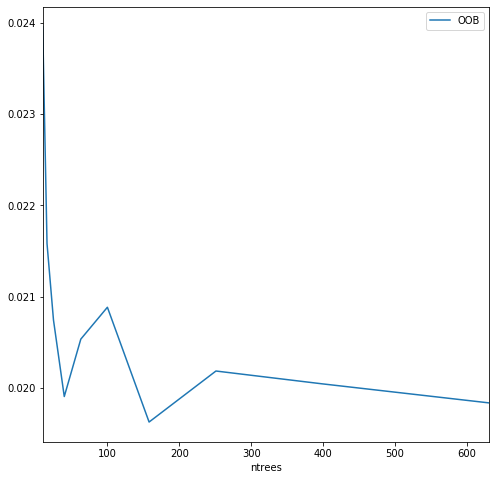

In [84]:
rf_results.plot(x='ntrees',y='OOB',figsize=(8,8));
rf_results

We see that the best number of trees is approximately between 100 and 250, let's try with values in that range

,ntrees,OOB
0,100,0.019835
1,110,0.019695
2,120,0.019486
3,130,0.020324
4,140,0.019695
5,150,0.019695
6,160,0.019835
7,170,0.020115
8,180,0.020045
9,190,0.020045


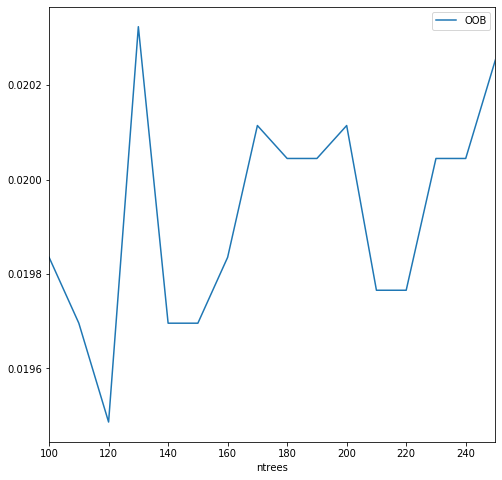

In [87]:
ntrees = np.array(range(10, 26))*10
rf_results = optimize_ntrees(X_train, y_train, ntrees)
rf_results.plot(x='ntrees',y='OOB',figsize=(8,8));
rf_results

In [88]:
rf_results.loc[rf_results.OOB.idxmin]

ntrees    120.000000
OOB         0.019486
Name: 2, dtype: float64

In [96]:
RF = RandomForestClassifier(n_estimators=rf_results.ntrees.loc[rf_results.OOB.idxmin], 
                                          oob_score=True,
                                          n_jobs = -1,
                                          class_weight = class_weight);

best_model = RF.fit(X_train, y_train)

y_pred = best_model.predict(X_train)

print("Training Error:")
print((1-accuracy_score(y_train, y_pred))*100)

confusionMatrix(y_train, y_pred, classes = [0,1])

Training Error:
0.006984215672578564


Predicted,0,1
Real,,
0,13020,0
1,1,1297


In [97]:
# Save model
RFFile = open('./models/RF_Best_Data_pickle_file', 'wb')
pickle.dump(best_model, RFFile) 

### No-correlated Data Training

Now with no-correlated data

In [103]:
ntrees = np.array(np.round(10**np.arange(1,3,0.2)),dtype=int)
rf_results = optimize_ntrees(X_train_NC, y_train_NC, ntrees)

/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ferja/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,ntrees,OOB
0,10,0.025073
1,16,0.020673
2,25,0.020115
3,40,0.021022
4,63,0.019905
5,100,0.020184
6,158,0.019486
7,251,0.019626
8,398,0.019556
9,631,0.019905


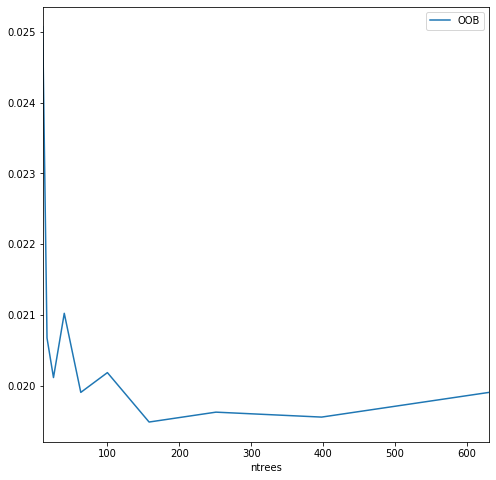

In [104]:
rf_results.plot(x='ntrees',y='OOB',figsize=(8,8));
rf_results

We see that the best number of trees is approximately between 100 and 250, let's try with values in that range

,ntrees,OOB
0,100,0.019556
1,110,0.019905
2,120,0.019835
3,130,0.020324
4,140,0.020184
5,150,0.019695
6,160,0.020045
7,170,0.020184
8,180,0.020184
9,190,0.020184


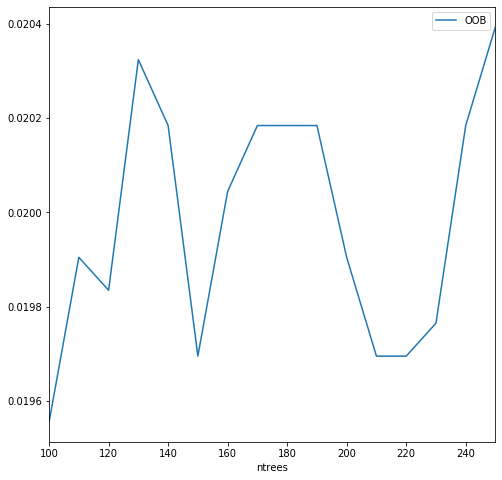

In [106]:
ntrees = np.array(range(10, 26))*10
rf_results = optimize_ntrees(X_train_NC, y_train_NC, ntrees)
rf_results.plot(x='ntrees',y='OOB',figsize=(8,8));
rf_results

In [107]:
rf_results.loc[rf_results.OOB.idxmin]

ntrees    100.000000
OOB         0.019556
Name: 0, dtype: float64

In [110]:
RF = RandomForestClassifier(n_estimators=rf_results.ntrees.loc[rf_results.OOB.idxmin], 
                                          oob_score=True,
                                          n_jobs = -1,
                                          class_weight = class_weight);

best_model_NC = RF.fit(X_train_NC, y_train_NC)

y_pred_NC = best_model_NC.predict(X_train_NC)

print("Training Error:")
print((1-accuracy_score(y_train_NC, y_pred_NC))*100)

confusionMatrix(y_train_NC, y_pred_NC, classes = [0,1])

Training Error:
0.006984215672578564


Predicted,0,1
Real,,
0,13020,0
1,1,1297


In [115]:
# Save model
RFFileNC = open('./models/RF_Best_Data_NC_pickle_file', 'wb')
pickle.dump(best_model_NC, RFFileNC)

## Testing 

### Normal Data Model Testing

In [98]:
y_pred = best_model.predict(X_test)
confusionMatrix(y_test, y_pred, classes = [0,1])

Predicted,0,1
Real,,
0,3210,29
1,56,285


In [99]:
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.98      0.99      0.99      3239
         yes       0.91      0.84      0.87       341

    accuracy                           0.98      3580
   macro avg       0.95      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580



In [100]:
print("Testing Error:")
print((1-accuracy_score(y_test, y_pred))*100)

Testing Error:
2.3743016759776525


### No-correlated Data Model Testing

In [112]:
y_pred_NC = best_model_NC.predict(X_test_NC)
confusionMatrix(y_test_NC, y_pred_NC, classes = [0,1])

Predicted,0,1
Real,,
0,3207,32
1,55,286


In [113]:
print(classification_report(y_test_NC, y_pred_NC, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.98      0.99      0.99      3239
         yes       0.90      0.84      0.87       341

    accuracy                           0.98      3580
   macro avg       0.94      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580



In [114]:
print("Testing Error:")
print((1-accuracy_score(y_test_NC, y_pred_NC))*100)

Testing Error:
2.4301675977653647
